# Results Markov

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())
import math

import src.ml.markov as mk
from src.dao.experiments_dao import load_execution_test_data_by_model

from src.exceptions import exceptions

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

working dir /home/tales/dev/master/mdc_analysis


## Loading data

In [2]:
def round_up_list(num_list):
    rounded = [math.ceil(i) for i in num_list]
    return rounded

def json_to_dataframe(json_list, simple_cols=True):
    df = pd.DataFrame(json_list)
    
    df["iteration"] = df["iteration"].astype(str)
    df["k"] = df["k"].astype(str)
    
    df["acc"] = df["total_hits"] / (df["total_hits"] + df["total_misses"])
    
    df["partial_hits_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(lista).mean())
    
    df["hits_contain"] = df["partial_hits"].apply(lambda lista : round_up_list(lista))
    df["hits_contain_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(round_up_list(lista)).mean())
    
    if simple_cols:
        del df["states_not_trained_as_origin"]
        del df["hits"]
        del df["misses"]
        
    return df

In [3]:
results_dir = "markov_model"

mk_results = load_execution_test_data_by_model(results_dir)
print("{} tests".format(len(mk_results)))

r = json_to_dataframe(mk_results, simple_cols=False)
r.sample(4)

4708 tests


,hits,input_data_version,is_distributive,iteration,k,method,misses,partial_hits,states_not_trained_as_origin,test_id,...,total_hits,total_misses,total_states_not_trained_as_origin,train_size,trained_with,user_id,acc,partial_hits_mean,hits_contain,hits_contain_mean
4377,"[['HOME'], ['WORK']]",markov-0.0.d,True,3.0,4.0,k_fold,"[{'real': '['WORK']', 'pred': '['park']'}, {'r...","[0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.3333333333333...","[['moving_company', 'storage']]",67ed87d0-eece-40ef-9db0-538604181f56,...,2,74,1,231,same_user,6058,0.026,0.093,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...",0.250
4197,"[['health'], ['store'], ['HOME'], ['store'], [...",markov-0.0.categ_v1,False,1.0,4.0,k_fold,"[{'real': '['cafe']', 'pred': '['lawyer']'}, {...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",[],830b21f2-55a6-443a-ae4a-2b801e2d8136,...,10,43,0,165,same_user,6028,0.189,0.189,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",0.189
3951,"[['HOME'], ['store'], ['restaurant'], ['WORK']...",markov-0.0.categ_v1-DUMMY,False,nan,nan,all_users_vs_one-dummy,"[{'real': '['HOME']', 'pred': '['lodging']'}, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",[],a7beef6c-7bab-4c6c-a5d7-532e2a64e096,...,5,127,0,48209,all_other_users,5943,0.038,0.038,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.038
2203,"[['WORK'], ['HOME'], ['HOME'], ['WORK'], ['HOM...",markov-0.0,False,0.0,4.0,k_fold,"[{'real': '['WORK']', 'pred': '['locality', 'p...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[['insurance_agency'], ['cafe', 'food', 'real_...",bb775aa0-587c-464a-b3e9-72121a00fd72,...,40,128,13,546,same_user,5967,0.238,0.247,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",0.262


## Summary

In [4]:
r["input_data_version"].value_counts()

markov-0.0-DUMMY             787
markov-0.0                   787
markov-0.0.d                 787
markov-0.0.d-DUMMY           787
markov-0.0.categ_v1-DUMMY    780
markov-0.0.categ_v1          780
Name: input_data_version, dtype: int64

In [5]:
r["input_data_version"].value_counts().plot.bar(title="input_data_version", figsize=(4,2))

In [6]:
r["method"].value_counts()

k_fold                    1872
k_fold-dummy              1872
all_users_vs_one           482
all_users_vs_one-dummy     482
Name: method, dtype: int64

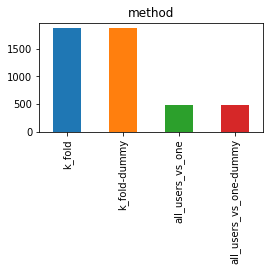

In [7]:
r["method"].value_counts().plot.bar(title="method", figsize=(4,2))

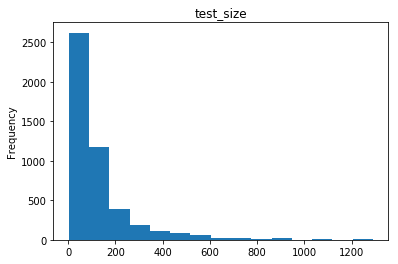

In [8]:
r["test_size"].plot.hist(title="test_size", bins=15)

## Accuracy

In [9]:
def markov_accuracy(results):
    return results["total_hits"].sum() / (results["total_hits"].sum() + results["total_misses"].sum())

In [10]:
results = []

### markov-0.0

In [11]:
hist_plot = []

use_data = r[r["input_data_version"] == "markov-0.0"]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    print("method: {}".format(method))
    print()
    acc = use_results["acc"].median()
    print("    Accuracy: {0:.4f}".format(acc))
    mad = use_results["acc"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(mad))
    print("    ---")
    p_acc = use_results["partial_hits_mean"].median()
    print("    Partial Hits Mean: {0:.4f}".format(p_acc))
    p_mad = use_results["partial_hits_mean"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(p_mad))
    print("    ---")
    contain_acc = use_results["hits_contain_mean"].mean()
    print("    Contains Partial Hits Mean: {0:.4f}".format(contain_acc))
    print("    ---")
    print()
    results.append({"method": method, "acc": acc, "partial_acc": p_acc, "mad": mad, "partial_mad": p_mad, "input_data": "markov-0.0", "contains_acc": contain_acc})


method: all_users_vs_one

    Accuracy: 0.0392
    Mean Absolute Deviation: 0.0283
    ---
    Partial Hits Mean: 0.0700
    Mean Absolute Deviation: 0.0279
    ---
    Contains Partial Hits Mean: 0.1288
    ---

method: k_fold

    Accuracy: 0.1304
    Mean Absolute Deviation: 0.0902
    ---
    Partial Hits Mean: 0.1631
    Mean Absolute Deviation: 0.0876
    ---
    Contains Partial Hits Mean: 0.2345
    ---



### markov-0.0.d

In [12]:
hist_plot = []

use_data = r[r["input_data_version"] == "markov-0.0.d"]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    print("method: {}".format(method))
    print()
    acc = use_results["acc"].median()
    print("    Accuracy: {0:.4f}".format(acc))
    mad = use_results["acc"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(mad))
    print("    ---")
    p_acc = use_results["partial_hits_mean"].median()
    print("    Partial Hits Mean: {0:.4f}".format(p_acc))
    p_mad = use_results["partial_hits_mean"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(p_mad))
    print("    ---")
    contain_acc = use_results["hits_contain_mean"].mean()
    print("    Contains Partial Hits Mean: {0:.4f}".format(contain_acc))
    print("    ---")
    print()
    results.append({"method": method, "acc": acc, "partial_acc": p_acc, "mad": mad, "partial_mad": p_mad, "input_data": "markov-0.0.d", "contains_acc": contain_acc})


method: all_users_vs_one

    Accuracy: 0.0147
    Mean Absolute Deviation: 0.0160
    ---
    Partial Hits Mean: 0.0598
    Mean Absolute Deviation: 0.0170
    ---
    Contains Partial Hits Mean: 0.1478
    ---

method: k_fold

    Accuracy: 0.0373
    Mean Absolute Deviation: 0.0535
    ---
    Partial Hits Mean: 0.1115
    Mean Absolute Deviation: 0.0587
    ---
    Contains Partial Hits Mean: 0.2419
    ---



In [13]:
hist_plot = []

use_data = r[r["input_data_version"] == "markov-0.0.categ_v1"]

for method in use_data["method"].drop_duplicates().sort_values():
    use_results = use_data[use_data["method"] == method]
    print("method: {}".format(method))
    print()
    acc = use_results["acc"].median()
    print("    Accuracy: {0:.4f}".format(acc))
    mad = use_results["acc"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(mad))
    print("    ---")
    p_acc = use_results["partial_hits_mean"].median()
    print("    Partial Hits Mean: {0:.4f}".format(p_acc))
    p_mad = use_results["partial_hits_mean"].mad()
    print("    Mean Absolute Deviation: {0:.4f}".format(p_mad))
    print("    ---")
    contain_acc = use_results["hits_contain_mean"].mean()
    print("    Contains Partial Hits Mean: {0:.4f}".format(contain_acc))
    print("    ---")
    print()
    results.append({"method": method, "acc": acc, "partial_acc": p_acc, "mad": mad, "partial_mad": p_mad, "input_data": "markov-0.0.d", "contains_acc": contain_acc})


method: all_users_vs_one

    Accuracy: 0.0869
    Mean Absolute Deviation: 0.0273
    ---
    Partial Hits Mean: 0.0869
    Mean Absolute Deviation: 0.0273
    ---
    Contains Partial Hits Mean: 0.0885
    ---

method: k_fold

    Accuracy: 0.1611
    Mean Absolute Deviation: 0.0846
    ---
    Partial Hits Mean: 0.1611
    Mean Absolute Deviation: 0.0846
    ---
    Contains Partial Hits Mean: 0.1808
    ---



In [14]:
results_df = pd.DataFrame(results)
results_df

,acc,contains_acc,input_data,mad,method,partial_acc,partial_mad
0,0.039,0.129,markov-0.0,0.028,all_users_vs_one,0.070,0.028
1,0.130,0.235,markov-0.0,0.090,k_fold,0.163,0.088
2,0.015,0.148,markov-0.0.d,0.016,all_users_vs_one,0.060,0.017
3,0.037,0.242,markov-0.0.d,0.054,k_fold,0.112,0.059
4,0.087,0.089,markov-0.0.d,0.027,all_users_vs_one,0.087,0.027
5,0.161,0.181,markov-0.0.d,0.085,k_fold,0.161,0.085


# Complete matching accuracy

### Overview

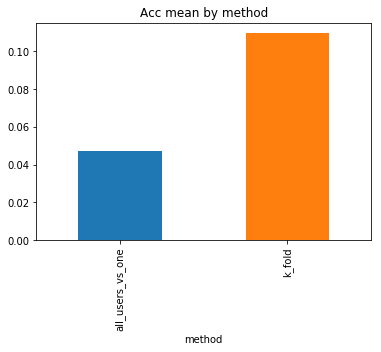

In [15]:
results_df.set_index("method").groupby("method").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by method")

In [16]:
#results_df.set_index("input_data").groupby("input_data").apply(lambda value : value.mean())["contains_acc"].plot.bar(title="Acc mean by method")

### Complete Array Matching

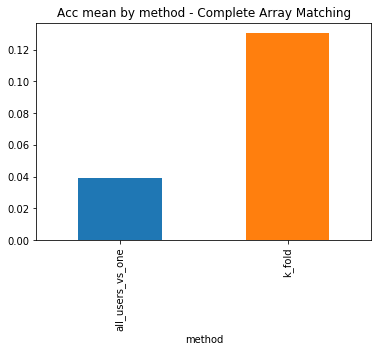

In [17]:
results_df[results_df["input_data"] == "markov-0.0"].set_index("method").groupby("method").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by method - Complete Array Matching")

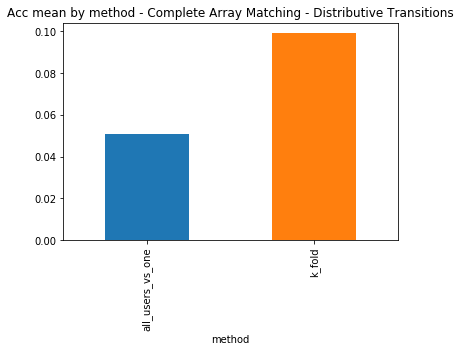

In [18]:
results_df[results_df["input_data"] == "markov-0.0.d"].set_index("method").groupby("method").apply(lambda value : value.mean())["acc"].plot.bar(title="Acc mean by method - Complete Array Matching - Distributive Transitions")

### Partial Array Matching (Jaccard)

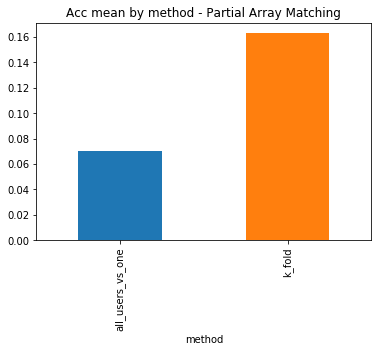

In [19]:
results_df[results_df["input_data"] == "markov-0.0"].set_index("method").groupby("method").apply(lambda value : value.mean())["partial_acc"].plot.bar(title="Acc mean by method - Partial Array Matching")

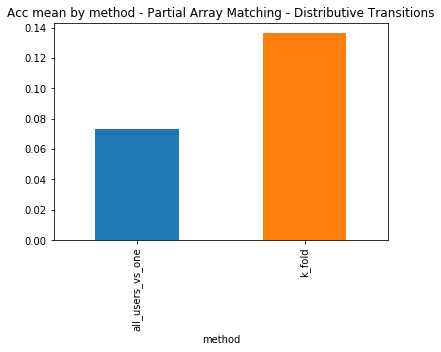

In [20]:
results_df[results_df["input_data"] == "markov-0.0.d"].set_index("method").groupby("method").apply(lambda value : value.mean())["partial_acc"].plot.bar(title="Acc mean by method - Partial Array Matching - Distributive Transitions")

### Real Array Type Contains Any Predicted Type

[A, B] [X,A,Z] <BR>
[C] [A,B,C]

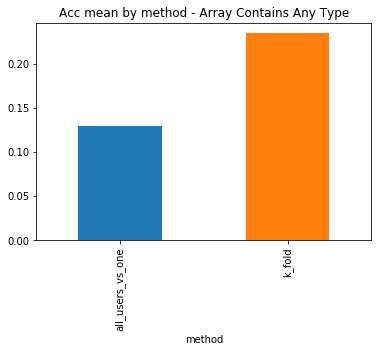

In [21]:
results_df[results_df["input_data"] == "markov-0.0"].set_index("method").groupby("method").apply(lambda value : value.mean())["contains_acc"].plot.bar(title="Acc mean by method - Array Contains Any Type")

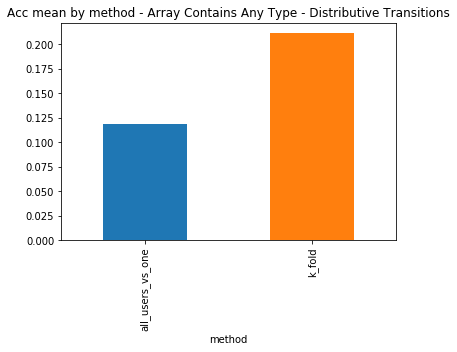

In [22]:
results_df[results_df["input_data"] == "markov-0.0.d"].set_index("method").groupby("method").apply(lambda value : value.mean())["contains_acc"].plot.bar(title="Acc mean by method - Array Contains Any Type - Distributive Transitions")